# Project:
# Web Scraping Job Postings and Predicting Salary and Job Categories



### EDA: Figuring out what is in the data set and engineering features for my analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from HTMLParser import HTMLParser
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import WordPunctTokenizer
from textblob import TextBlob
from textacy.preprocess import preprocess_text
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import patsy
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import os
from gensim import corpora, models, matutils
from collections import defaultdict

In [2]:
df = pd.read_csv('./indeed_job_listings.csv', sep=',', encoding='utf-8', index_col=None)

df.shape

(1960, 20)

In [3]:
df.head()

,city,company,country,date,expired,formattedLocation,formattedLocationFull,formattedRelativeTime,indeedApply,jobkey,jobtitle,language,onmousedown,snippet,source,sponsored,state,stations,url,search_term
0,Redmond,Microsoft,US,"Thu, 01 Jun 2017 07:22:12 GMT",False,"Redmond, WA","Redmond, WA 98052",8 hours ago,False,8f2960110f91289e,Principal Data Scientist,en,"indeed_clk(this,'4341');",We are looking for an experienced principal le...,Microsoft,False,WA,NaN,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science
1,Seattle,Facebook,US,"Wed, 31 May 2017 23:57:15 GMT",False,"Seattle, WA","Seattle, WA",16 hours ago,False,c822b64a1008e72a,"Data Scientist, Analytics",en,"indeed_clk(this,'4341');",The <b>Data</b> <b>Scientist</b> Analytics rol...,Facebook,False,WA,NaN,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science
2,Seattle,Amazon Corporate LLC,US,"Thu, 01 Jun 2017 01:01:55 GMT",False,"Seattle, WA","Seattle, WA",15 hours ago,False,088d06342a3c0613,Data Scientist,en,"indeed_clk(this,'4341');",Amazon is seeking a <b>Data</b> <b>Scientist</...,Amazon.com,False,WA,NaN,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science
3,Seattle,Amazon Corporate LLC,US,"Thu, 01 Jun 2017 01:01:44 GMT",False,"Seattle, WA","Seattle, WA",15 hours ago,False,219629e50af0388b,Data Engineer,en,"indeed_clk(this,'4341');",3+ years in relevant experience as <b>data</b>...,Amazon.com,False,WA,NaN,http://www.indeed.com/viewjob?jk=219629e50af03...,data science
4,Renton,XDuce,US,"Thu, 01 Jun 2017 03:28:18 GMT",False,"Renton, WA","Renton, WA",12 hours ago,False,020aaa78301c721d,Associate Technical Architect,en,"indeed_clk(this,'4341');",Senior programmer or <b>Data</b> <b>scientist<...,XDuce,False,WA,NaN,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 20 columns):
city                     1960 non-null object
company                  1960 non-null object
country                  1960 non-null object
date                     1960 non-null object
expired                  1960 non-null bool
formattedLocation        1960 non-null object
formattedLocationFull    1960 non-null object
formattedRelativeTime    1960 non-null object
indeedApply              1960 non-null bool
jobkey                   1960 non-null object
jobtitle                 1960 non-null object
language                 1960 non-null object
onmousedown              1960 non-null object
snippet                  1960 non-null object
source                   1960 non-null object
sponsored                1960 non-null bool
state                    1960 non-null object
stations                 0 non-null float64
url                      1960 non-null object
search_term              19

In [5]:
# There is nothing in the 'stations' column, so it should be deleted.

df.drop(['stations'], inplace=True, axis=1)

df.shape

(1960, 19)

In [6]:
df['expired'].value_counts()

False    1960
Name: expired, dtype: int64

In [7]:
# All of the listings are current, so the 'expired' column is not informative and can be deleted.

df.drop(['expired'], inplace=True, axis=1)

df.shape

(1960, 18)

In [8]:
# The source is often the same as the company, so this column can also be deleted.

df['source'].value_counts()

Amazon.com                                               758
Microsoft                                                179
Tableau                                                  114
Indeed                                                   109
Expedia                                                   21
Textio                                                    18
Lab126                                                    18
MetroPCS                                                  16
Nordstrom                                                 16
Oculus VR                                                 15
Facebook                                                  15
Diverse Lynx                                              15
HERE                                                      13
Posh Technologies                                         12
Starbucks                                                 11
Harvey Nash                                                9
Zillow Group            

In [9]:
df.columns

Index([u'city', u'company', u'country', u'date', u'formattedLocation',
       u'formattedLocationFull', u'formattedRelativeTime', u'indeedApply',
       u'jobkey', u'jobtitle', u'language', u'onmousedown', u'snippet',
       u'source', u'sponsored', u'state', u'url', u'search_term'],
      dtype='object')

In [10]:
# Other columns that can be deleted are: country, formattedLocation, formattedLocationFull, formattedRelativeTime,
# indeedApply, language, onmousedown, source, sponsored, and state. Some of these contain only a single value for
# all rows (e.g., state = 'WA', language = 'en'), and some are just not relevant to this analysis (e.g., 'onmousedown').

df.drop(['country'], inplace=True, axis=1)
df.drop(['formattedLocation'], inplace=True, axis=1)
df.drop(['formattedLocationFull'], inplace=True, axis=1)
df.drop(['formattedRelativeTime'], inplace=True, axis=1)
df.drop(['indeedApply'], inplace=True, axis=1)
df.drop(['language'], inplace=True, axis=1)
df.drop(['onmousedown'], inplace=True, axis=1)
df.drop(['source'], inplace=True, axis=1)
df.drop(['sponsored'], inplace=True, axis=1)
df.drop(['state'], inplace=True, axis=1)
df.drop(['date'], inplace=True, axis=1)

In [11]:
df.shape

(1960, 7)

In [12]:
df.columns

Index([u'city', u'company', u'jobkey', u'jobtitle', u'snippet', u'url',
       u'search_term'],
      dtype='object')

In [13]:
# Printing summary information about the remaining columns.

print 'shape: %d rows, %d cols\n' % df.shape
    
print 'column info:'
for col in df.columns:
    print '* %s: %d nulls, %d unique vals, most common: %s' % (
            col,
            df[col].isnull().sum(),
            df[col].nunique(),
            df[col].value_counts().head().to_dict()
        )
print '\n------\n'

shape: 1960 rows, 7 cols

column info:
* city: 0 nulls, 16 unique vals, most common: {u'Bellevue': 186, u'Seattle': 1422, u'Redmond': 263, u'Renton': 14, u'Kirkland': 30}
* company: 0 nulls, 439 unique vals, most common: {u'Amazon Web Services, Inc.': 56, u'Textio': 18, u'Microsoft': 180, u'Amazon Corporate LLC': 658, u'Tableau': 114}
* jobkey: 0 nulls, 1960 unique vals, most common: {u'05278c7ade2428b2': 1, u'825c380da3d8f969': 1, u'ffc7f09afed44214': 1, u'7e7667c2713713b0': 1, u'1472af44cec343dc': 1}
* jobtitle: 0 nulls, 1681 unique vals, most common: {u'Data Engineer': 14, u'Senior Data Scientist': 13, u'Data Scientist': 26, u'Data Analyst': 18, u'Software Engineer': 13}
* snippet: 0 nulls, 1618 unique vals, most common: {u"After a highly successful IPO in 2013, Tableau has become a market-defining company in the <b>business</b> <b>intelligence</b> industry. What you'll be doing\u2026....": 7, u'After a highly successful IPO in 2013, Tableau has become a market-defining company in t

### Visualizations

In [14]:
# The predictors for salary classes so far are city, company, jobtitle, search_term, and snippet.
# NLP on jobtitle and snippet will generate more predictor columns.

# Two other columns will stay in the DataFrame but not be used in modeling.
# Jobkey is a unique identifier for each job listing, which allowed me to detect and remove duplicates.
# Url might be useful later if I need more text about each listing.

In [15]:
# Taking a closer look at distributions:

# Filter categorical variables
categorical_columns = [x for x in df.dtypes.index if df.dtypes[x]=='object']

# Exclude columns that will not be predictors:
categorical_columns = [x for x in categorical_columns if x not in ['jobkey', 'url']]

categorical_columns

[u'city', u'company', u'jobtitle', u'snippet', u'search_term']

In [16]:
# Print frequency of categories
for col in categorical_columns:
    print '\nFrequency of Categories for varible %s'%col
    print df[col].value_counts()


Frequency of Categories for varible city
Seattle              1422
Redmond               263
Bellevue              186
Kirkland               30
Renton                 14
Bothell                13
Issaquah                8
Kent                    6
Everett                 5
Federal Way             3
Woodinville             2
Auburn                  2
Tukwila                 2
Lynnwood                2
Des Moines              1
Mountlake Terrace       1
Name: city, dtype: int64

Frequency of Categories for varible company
Amazon Corporate LLC                                      658
Microsoft                                                 180
Tableau                                                   114
Amazon Web Services, Inc.                                  56
Textio                                                     18
MetroPCS                                                   16
Nordstrom                                                  16
Diverse Lynx                          

In [17]:
# A few visualizations will help show what's in the data set, but there are a lot of unique text values 
# so it will be difficult to see everything that's in the data set visually.

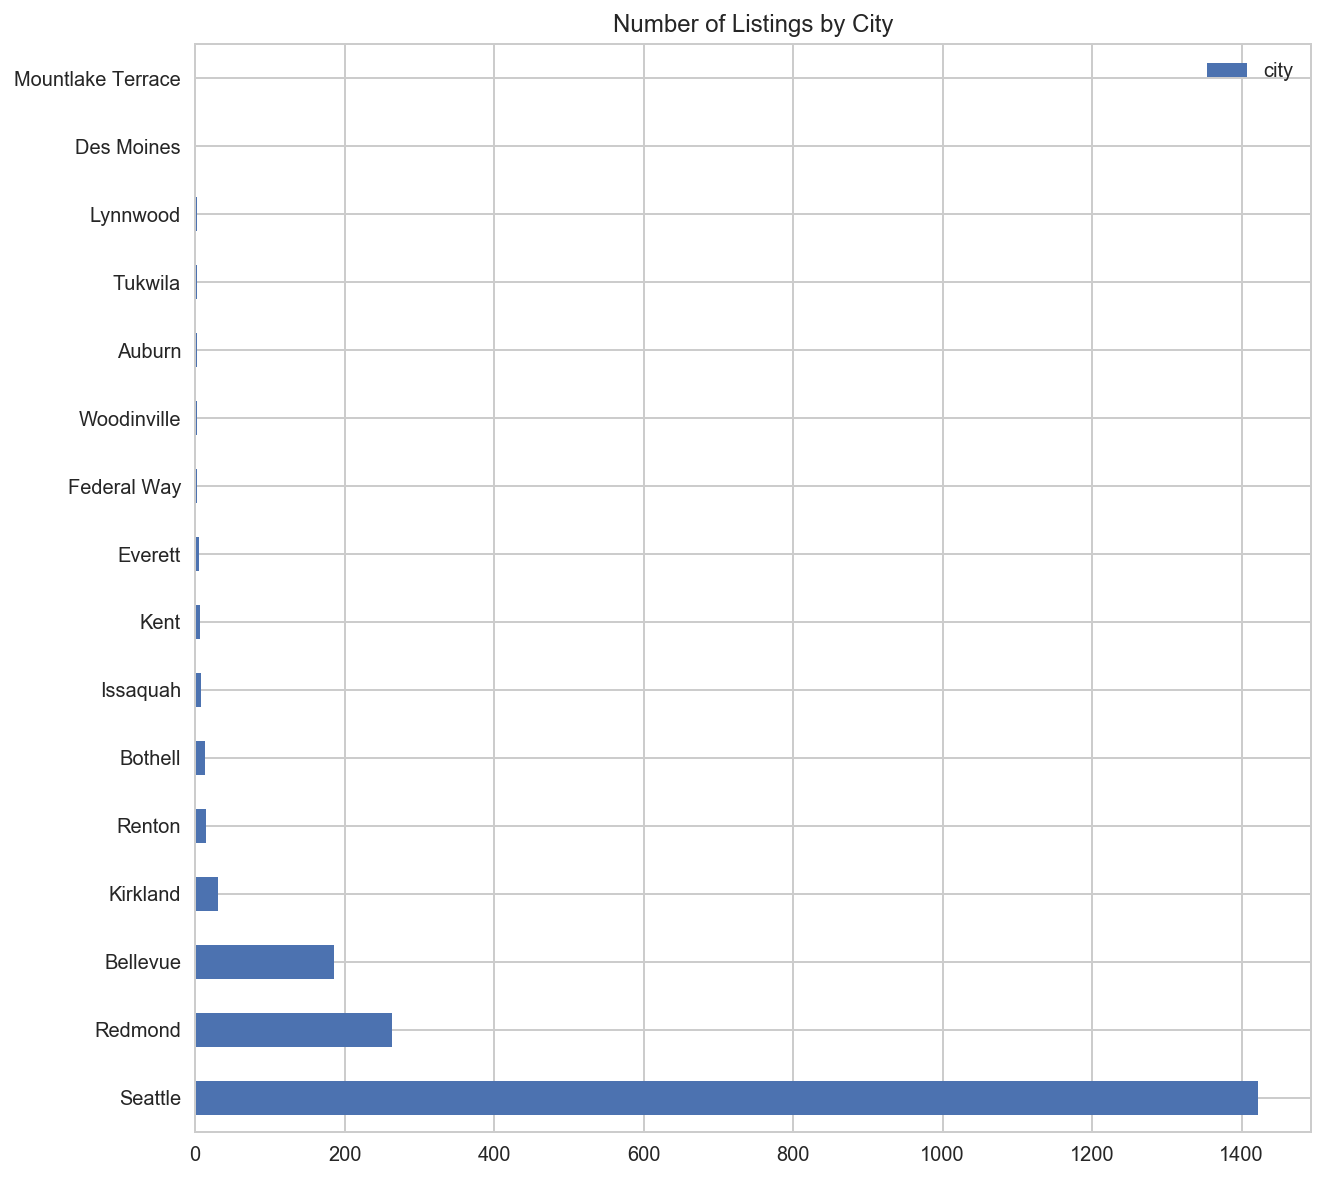

In [18]:
# The vast majority of job listings are for jobs in Seattle proper.
x = pd.DataFrame(df['city'].value_counts())
plt.figure()
x.plot.barh(title="Number of Listings by City", figsize=(10,10))

In [19]:
# By taking just the first word from the company names, I am able to group together various spellings of the same
# company. Single word labels will also display more clearly on the chart.

df['company_abbrev'] = [s.split(' ', 1)[0] for s in df['company']]

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce


In [20]:
len(df['company_abbrev'].unique())

397

In [21]:
# Visualizing the company predictor, for the most frequently appearing companies. (There are too many (397) to display
# them all in a chart.)

x = pd.DataFrame(df['company_abbrev'].value_counts())

x = x[x['company_abbrev'] >= 10]

x

,company_abbrev
Amazon,766
Microsoft,180
Tableau,114
Textio,18
Diverse,16
MetroPCS,16
Nordstrom,16
Facebook,15
Oculus,15
Expedia,15


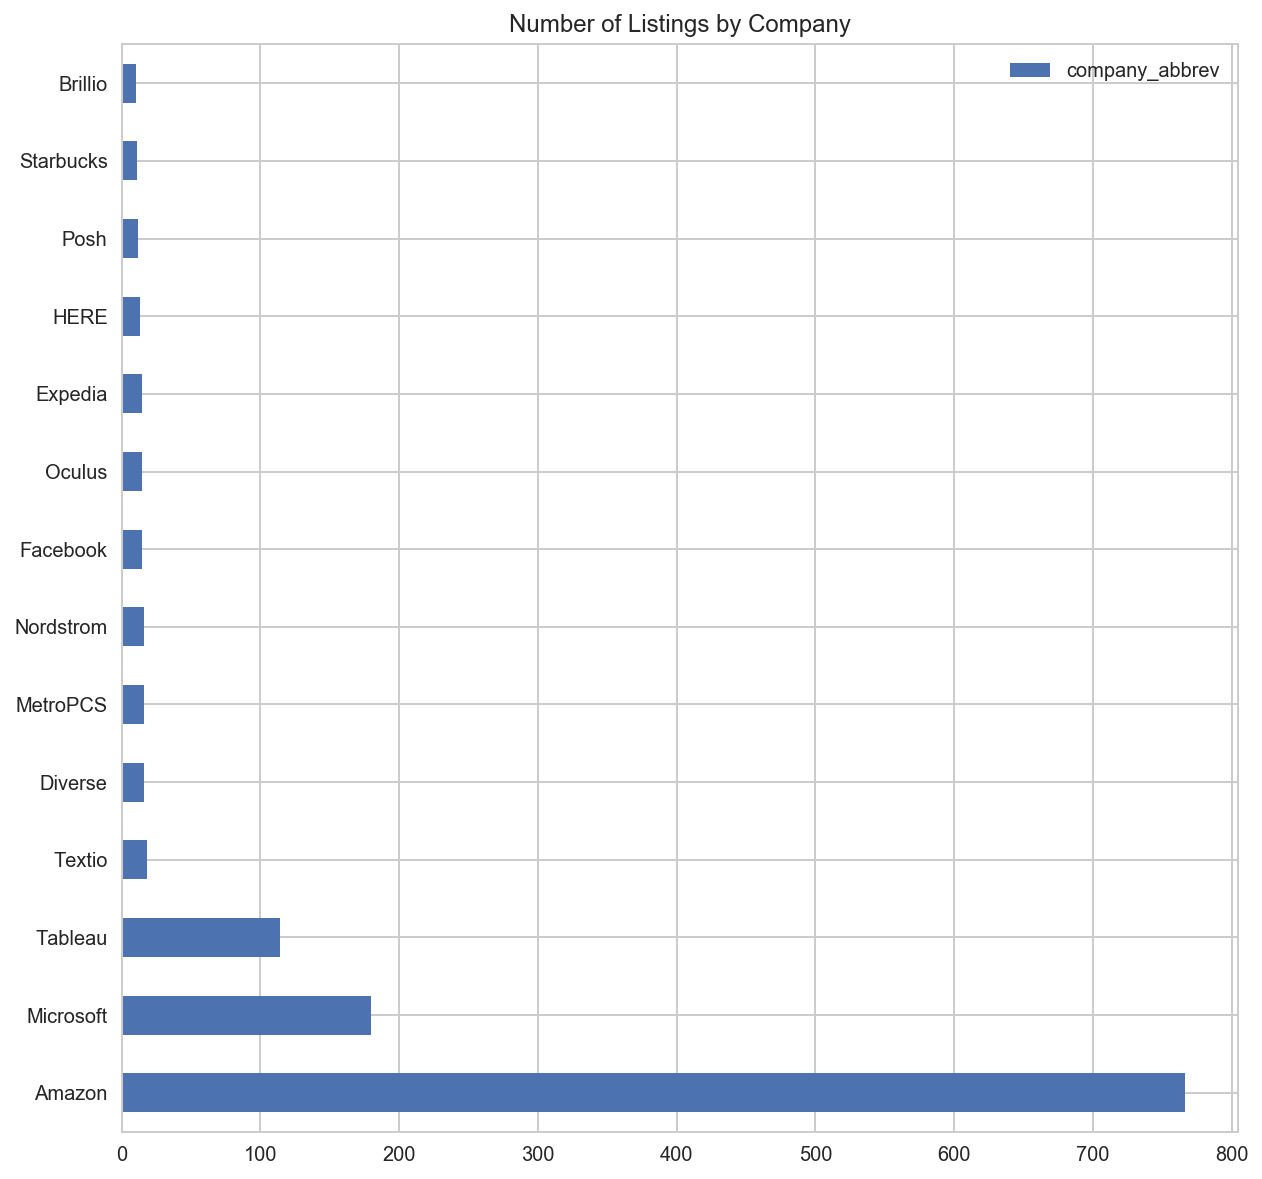

In [22]:
# Amazon accounts for almost 40% of these listings!
plt.figure()
x.plot.barh(title="Number of Listings by Company", figsize=(10,10))

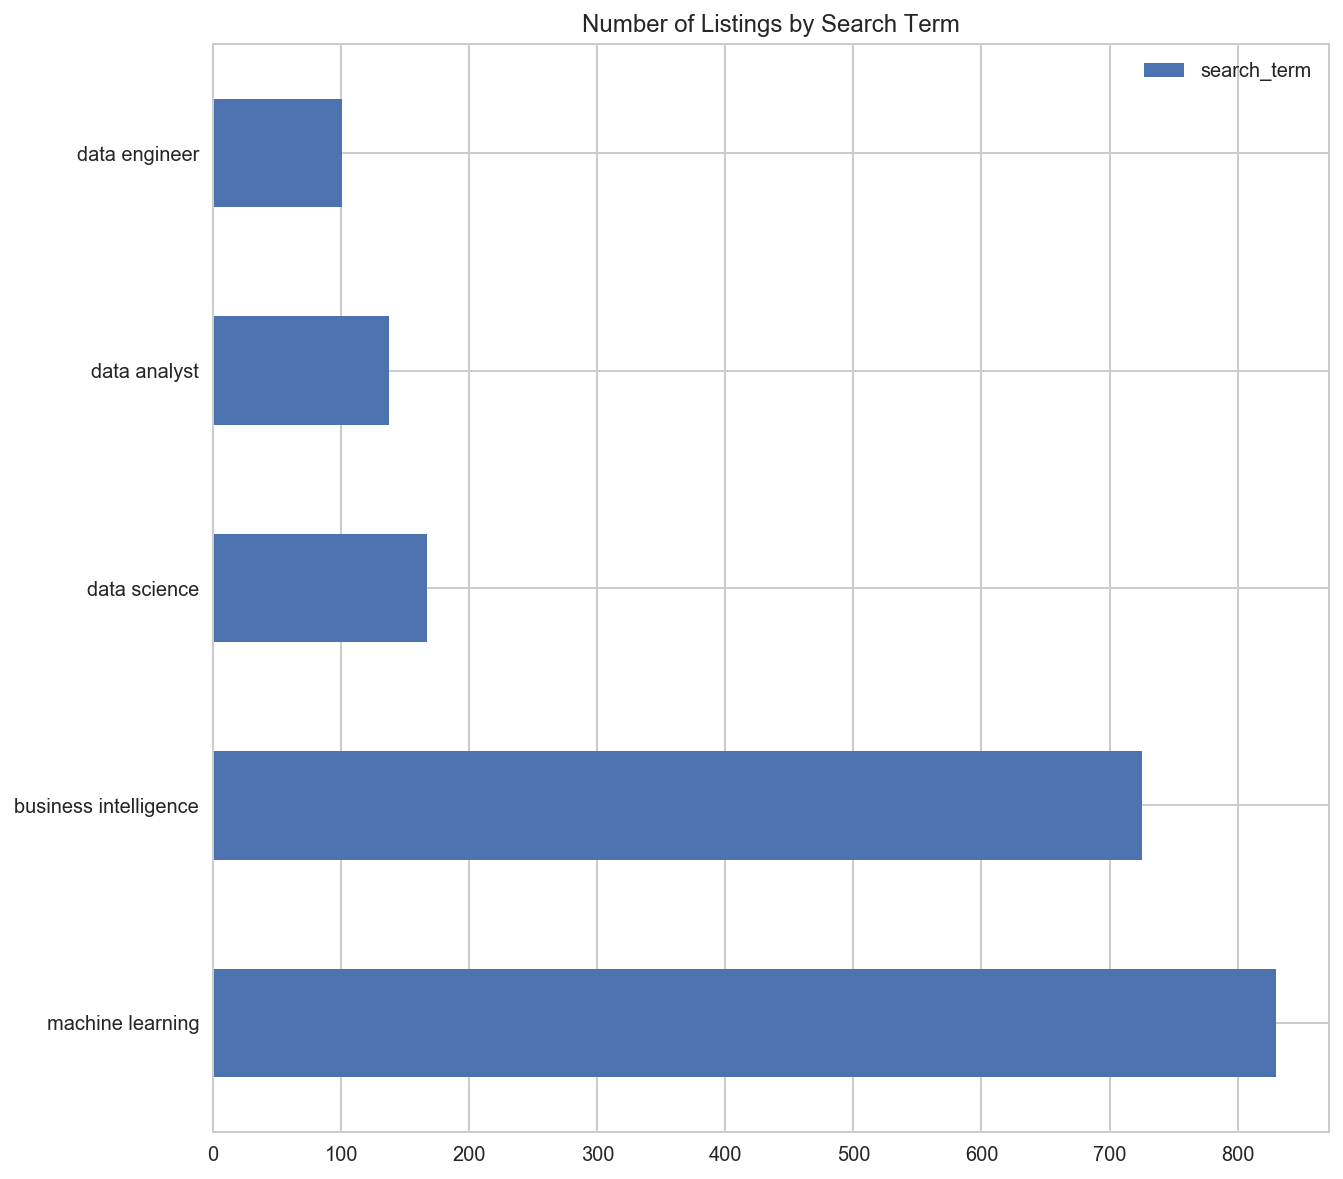

In [23]:
# Visualizing frequency according to search term used.
x = pd.DataFrame(df['search_term'].value_counts())
plt.figure()
x.plot.barh(title="Number of Listings by Search Term", figsize=(10,10))

### NLP on the job titles and snippets:

In [24]:
# calculating the length of the job titles

df['jobtitle_length'] = [len(s.split()) for s in df['jobtitle']]

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3


In [25]:
x = pd.DataFrame(df['jobtitle_length'].value_counts())

x.head()

,jobtitle_length
3,482
4,366
5,299
6,263
2,228


In [26]:
x.sort_index(ascending=True, inplace=True)

x.head()

,jobtitle_length
1,6
2,228
3,482
4,366
5,299


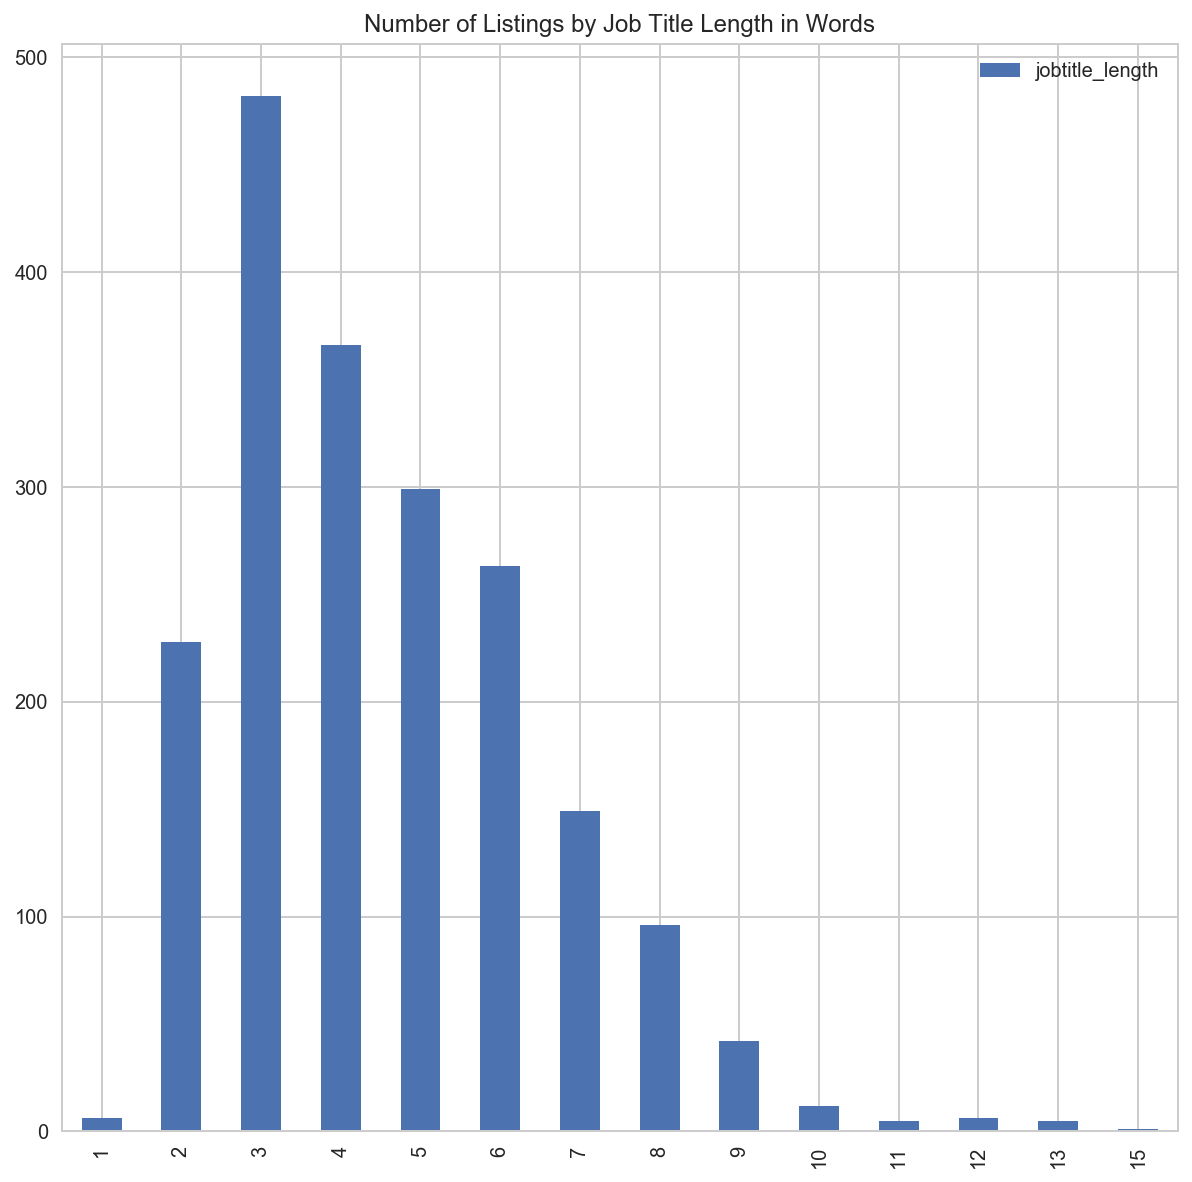

In [27]:
plt.figure()
x.plot.bar(title="Number of Listings by Job Title Length in Words", figsize=(10,10))

In [28]:
# Most job titles are 2-6 words long, but the distribution is skewed.

In [29]:
# creating a 'snippet_clean' and a 'jobtitle_clean' column without the html tags, punctuation, upper case letters, etc.

In [30]:
# to remove html tags
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [31]:
df['snippet_clean'] = df['snippet'].apply(strip_tags)
df['jobtitle_clean'] = df['jobtitle'].apply(strip_tags)

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,We are looking for an experienced principal le...,Principal Data Scientist
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,The Data Scientist Analytics role has work acr...,"Data Scientist, Analytics"
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,Amazon is seeking a Data Scientist to join the...,Data Scientist
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3+ years in relevant experience as data engine...,Data Engineer
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,Senior programmer or Data scientist. Experienc...,Associate Technical Architect


In [32]:
# Further preprocessing these text columns
df['snippet_clean'] = [preprocess_text(x, fix_unicode=True, lowercase=True, transliterate=False,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True)
              for x in df['snippet_clean']]
df['jobtitle_clean'] = [preprocess_text(x, fix_unicode=True, lowercase=True, transliterate=False,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True)
              for x in df['jobtitle_clean']]

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect


In [33]:
# extracting noun phrases from job titles and snippets using TextBlob

df['jobtitle_noun_phrases'] = [TextBlob(t).noun_phrases for t in df['jobtitle']]
df['snippet_noun_phrases'] = [TextBlob(t).noun_phrases for t in df['snippet_clean']]

df.head(15)

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da..."
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building..."
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci..."
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien..."
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,..."
5,Seattle,Smith Hanley Associates,05e8b637abe69887,Senior Data Scientist,Senior <b>Data</b> <b>Scientist</b>. Senior <b...,http://www.indeed.com/viewjob?jk=05e8b637abe69...,data science,Smith,3,senior data scientist senior data scientist re...,senior data scientist,[senior data scientist],[senior data scientist senior data scientist r...
6,Renton,Diverse Lynx,0bac624bd62ef8f2,Information Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=0bac624bd62ef...,data science,Diverse,2,senior programmer or data scientist experience...,information architect,[information architect],"[senior programmer, data scientist experience,..."
7,Redmond,Microsoft,7270fc61551a9b05,Data Scientist 2,You are a hands-on <b>data</b> <b>scientist</b...,http://www.indeed.com/viewjob?jk=7270fc61551a9...,data science,Microsoft,3,you are a handson data scientist with strong a...,data scientist 2,[data scientist],"[handson data scientist, strong algorithmic, m..."
8,Seattle,Amazon Corporate LLC,9c6ad92580fd4dcb,"Data Scientist, HIT",Experience with <b>data</b> visualization soft...,http://www.indeed.com/viewjob?jk=9c6ad92580fd4...,data science,Amazon,3,experience with data visualization software su...,data scientist hit,"[data scientist, hit]",[data visualization software]
9,Seattle,"Amazon Web Services, Inc.",b61a2b5ce2534910,Senior Data Scientist - AWS IoT Platform,As a Senior <b>Data</b> <b>Scientist</b> with ...,http://www.indeed.com/viewjob?jk=b61a2b5ce2534...,data science,Amazon,7,as a senior data scientist with iot you will h...,senior data scientist aws iot platform,"[senior data scientist, aws iot platform]","[senior data scientist, critical role, highnoi..."


In [34]:
# stemming the job titles and snippets
df['jobtitle_words'] = [TextBlob(x).words for x in df['jobtitle_clean']]
df['snippet_words'] = [TextBlob(x).words for x in df['snippet_clean']]

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases,jobtitle_words,snippet_words
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da...","[principal, data, scientist]","[we, are, looking, for, an, experienced, princ..."
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building...","[data, scientist, analytics]","[the, data, scientist, analytics, role, has, w..."
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci...","[data, scientist]","[amazon, is, seeking, a, data, scientist, to, ..."
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien...","[data, engineer]","[3, years, in, relevant, experience, as, data,..."
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,...","[associate, technical, architect]","[senior, programmer, or, data, scientist, expe..."


In [35]:
stemmer = SnowballStemmer('english')
df['jobtitle_stem'] = [[stemmer.stem(w) for w in word_list] for word_list in df['jobtitle_words']]
df['snippet_stem'] = [[stemmer.stem(w) for w in word_list] for word_list in df['snippet_words']]

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases,jobtitle_words,snippet_words,jobtitle_stem,snippet_stem
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da...","[principal, data, scientist]","[we, are, looking, for, an, experienced, princ...","[princip, data, scientist]","[we, are, look, for, an, experienc, princip, l..."
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building...","[data, scientist, analytics]","[the, data, scientist, analytics, role, has, w...","[data, scientist, analyt]","[the, data, scientist, analyt, role, has, work..."
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci...","[data, scientist]","[amazon, is, seeking, a, data, scientist, to, ...","[data, scientist]","[amazon, is, seek, a, data, scientist, to, joi..."
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien...","[data, engineer]","[3, years, in, relevant, experience, as, data,...","[data, engin]","[3, year, in, relev, experi, as, data, engin, ..."
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,...","[associate, technical, architect]","[senior, programmer, or, data, scientist, expe...","[associ, technic, architect]","[senior, programm, or, data, scientist, experi..."


In [36]:
# joining the lists of stemmed words back into single strings in order to perfrom vector counts
df['snippet_stem_string'] = [' '.join(x) for x in df['snippet_stem']]
df['jobtitle_stem_string'] = [' '.join(x) for x in df['jobtitle_stem']]

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases,jobtitle_words,snippet_words,jobtitle_stem,snippet_stem,snippet_stem_string,jobtitle_stem_string
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da...","[principal, data, scientist]","[we, are, looking, for, an, experienced, princ...","[princip, data, scientist]","[we, are, look, for, an, experienc, princip, l...",we are look for an experienc princip level dat...,princip data scientist
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building...","[data, scientist, analytics]","[the, data, scientist, analytics, role, has, w...","[data, scientist, analyt]","[the, data, scientist, analyt, role, has, work...",the data scientist analyt role has work across...,data scientist analyt
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci...","[data, scientist]","[amazon, is, seeking, a, data, scientist, to, ...","[data, scientist]","[amazon, is, seek, a, data, scientist, to, joi...",amazon is seek a data scientist to join the co...,data scientist
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien...","[data, engineer]","[3, years, in, relevant, experience, as, data,...","[data, engin]","[3, year, in, relev, experi, as, data, engin, ...",3 year in relev experi as data engin data scie...,data engin
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,...","[associate, technical, architect]","[senior, programmer, or, data, scientist, expe...","[associ, technic, architect]","[senior, programm, or, data, scientist, experi...",senior programm or data scientist experi with ...,associ technic architect


In [37]:
# getting vector counts on the snippets

cvec_sn = CountVectorizer(stop_words='english', max_features=1000)
cvec_sn.fit(df['snippet_stem_string'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
cvec_sn_df = pd.DataFrame(cvec_sn.transform(df['snippet_stem_string']).todense(), columns=cvec_sn.get_feature_names())

In [39]:
cvec_sn_df.head()

,10,12,2012,2013,250,2mm,35,365,3d,ab,abil,abl,abov,academ,acceler,access,account,accur,accuraci,achiev,acquir,acquisit,act,action,activ,acumen,ad,add,addit,address,adhoc,administr,adopt,advanc,advertis,aft,agent,agil,ai,aim,alexa,algorithm,align,allow,amazon,amazoncom,amazonian,ambiti,america,aml,analys,analysi,analyst,analyt,analyz,andor,ani,anoth,answer,api,app,appli,applic,applied,approach,appropri,architect,architectur,area,art,artifici,ask,aspect,assist,attent,audienc,audio,audit,author,autom,automot,autonom,avail,aw,azur,b2b,bachelor,backend,background,base,basic,bayesian,becom,behavior,believ,best,better,bi,bie,big,billion,bing,blend,blueprint,bonus,box,brand,breadth,bring,broad,build,built,busi,businessen,buy,california,camera,campaign,candid,capabl,captur,card,care,career,case,cassandra,catalog,categori,caus,cc,cda,celgen,center,central,certif,chain,challeng,champion,chang,channel,choic,citizen,class,classif,classifi,clean,cleans,clear,client,clientapp,clinic,close,cloud,cloudbas,cluster,code,cognit,cogno,collabor,collect,combin,come,comfort,commerc,commerci,common,communic,compani,compar,compil,complet,complex,complianc,complic,compon,comprehens,comput,concept,concur,conduct,configur,connect,constant,construct,consult,consum,consumpt,contemporari,content,contextbas,continu,contract,contribut,control,convers,coordin,core,corpor,cortana,cosmos,cost,coupang,coupl,creat,creation,creativ,critic,crm,cross,crossfunct,crosssel,cs,cultur,current,custom,custombuilt,customercentr,customerfac,customerobsess,cut,cuttingedg,cycl,dashboard,data,databas,databasesdata,datadriven,datamodel,dataset,day,decis,decisionmak,dedic,deep,deepen,deepli,defect,defin,definit,degre,deliv,deliveri,demand,demonstr,depart,depend,deploy,depth,descript,design,desir,detect,determin,develop,devic,didnt,differ,differenti,digit,dimension,direct,director,disciplin,discov,discoveri,dispar,disrupt,distil,distribut,dive,divers,document,dollar,domain,dramat,draw,drive,driven,driver,durat,dw,dynam,earli,easi,echo,ecommerc,econom,econometr,economist,edg,educ,effect,effici,effort,elast,element,elicit,email,embed,emerg,emphasi,employ,employe,empow,enabl,encompass,end,endtoend,endus,engag,engin,enhanc,enjoy,ensur,enterpris,entir,entiti,entri,environ,envis,equal,equival,especi,establish,estim,etl,etlelt,evalu,eventu,everi,everyday,everyth,exampl,excel,excit,execut,exist,expand,expans,expect,experi,experienc,experiment,expert,expertis,explor,exploratori,exposur,extend,extens,extern,extract,extrem,face,facebook,facilit,factori,familiar,fashion,fast,fastpac,fba,featur,feedback,field,filter,financ,financi,firm,flow,focus,follow,forecast,formul,foundat,framework,fraud,frontend,fulfil,fulli,fun,function,fundament,fusion,futur,game,gather,gc,general,generat,geodata,geometri,global,goal,good,govern,graph,graphic,great,ground,groundbreak,group,grow,growth,guid,guidanc,hadoop,hand,handl,handson,happen,hard,hardest,hardwar,health,healthcar,help,hesh,heterogen,high,highdimension,highperform,highvolum,hire,histor,histori,hive,holograph,home,hpc,hr,huge,human,humancomput,hundr,idea,ideal,ideat,identifi,ii,imag,immedi,impact,implement,import,improv,inaccess,includ,incorpor,increas,indepth,individu,industri,infer,influenc,inform,infrastructur,ingest,initi,innov,insid,insight,inspir,instrument,integr,intel,intellig,intelligencecustom,interact,interfac,intern,internet,internetofth,interpret,intersect,interview,inventori,invest,investig,inviso,involv,iot,ipo,issu,item,iter,java,javascript,job,join,judgment,junki,just,keen,key,kind,kindl,know,knowledg,...,lake,landscap,languag,larg,largescal,largest,latest,launch,lead,leader,leadership,leadingedg,learn,legal,level,leverag,librari,life,lifecycl,like,line,linguist,list,live,local,locat,log,logic,logist,long,longterm,look,loss,lot,love,low,machin,maintain,mainten,make,manag,mandatori,mani,manipul,manual,map,mapreduc,market,marketdefin,marketplac,mart,mass,massiv,master,match,math,mathemat,matter,maxim,mba,measur,mechan,media,medic,meet,m

In [40]:
cvec_sn_top = cvec_sn_df.transpose().sort_values(0, ascending=False).head(15).transpose()

cvec_sn_top

,data,advanc,experienc,role,team,look,princip,level,play,scienc,lead,statist,scientist,maintain,develop
0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,2,0,0,1,1,0,0,0,0,0,0,0,2,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0
6,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [41]:
cvec_sn_top.shape

(1960, 15)

In [42]:
# getting vector counts on the job titles

cvec_jt = CountVectorizer(stop_words='english', max_features=600)
cvec_jt.fit(df['jobtitle_stem_string'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=600, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [43]:
cvec_jt_df = pd.DataFrame(cvec_jt.transform(df['jobtitle_stem_string']).todense(), columns=cvec_jt.get_feature_names())

In [44]:
cvec_jt_df.head()

,017023,2012,2017,3p,account,ace,acquisit,ad,administr,advanc,advertis,advisor,advisori,ai,air,alexa,algo,algorithm,amazon,amazonfresh,america,analysi,analyst,analystseattl,analyt,android,appli,applic,architect,architectur,area,artifici,assist,associ,assur,autom,aw,azur,b2b,backend,beauti,behavior,bi,bie,big,bing,biolog,block,brand,build,busi,buyer,calibr,campaign,capac,card,care,ce,center,central,certif,chain,classif,client,clinic,cloud,coach,commerc,commerci,communiti,compens,complianc,compon,comput,concept,confidenti,connect,consid,construct,consult,consultantbusi,consum,content,continu,contract,control,convert,coopinternship,coordin,core,corpor,cortana,cosmos,cost,counsel,credit,crm,crs,cs,csm,currenc,custom,cyber,d2cs,dac,danger,dashboard,data,databas,decis,deep,deliveri,demand,design,desk,desktop,dev,develop,devic,devop,digit,direct,director,discoveri,distribut,dynam,ec2,ecommerc,econom,economist,ecosystem,elast,email,emerg,enabl,end,engag,engin,engineeranalyst,engineerdata,engineertech,enterpris,estat,etl,evangelist,event,execut,expans,experi,expert,export,fall,fashion,fast,fatal,fba,fellowship,field,financ,financi,firetv,firmwar,flex,forecast,fp,frontend,fte,fulfil,fullstack,function,game,gameplay,generalist,geospati,ghrs,gift,global,good,googl,govern,grad,graduat,graphic,group,growth,hadoop,hardwar,head,health,healthcar,home,homeiot,hr,icim,ident,ii,iii,implement,improv,industri,inform,infrastructur,initi,innov,insid,insight,instock,instructor,integr,intellig,interfac,intern,internet,inventori,inviso,io,iot,java,javascriptreactful,job,jr,kindl,kit,label,lambda,languag,launch,lead,leader,learn,lend,level,licens,lifelong,local,locat,logist,loyalti,machin,manag,manageramazon,market,master,mechan,media,mgmt,mgr,microsoft,ml,mobil,model,monet,monitor,ms,mts1,multipl,music,na,nacf,nation,nativ,natur,net,network,new,nlp,northwest,offic,onboard,onli,onlin,op,open,oper,optic,optim,oracl,outbound,outlet,owner,paid,partner,parttim,passion,patent,payment,peopletech,percept,perform,person,pharmaci,phd,php,pipelin,plan,plant,platform,play,playback,plugin,pm,pnt,pnwseattl,pool,portfolio,portugues,posit,postdoc,postdoctor,potenti,power,pr,practic,preconstruct,predict,prep,prepar,presal,presid,prevent,price,prime,princip,principalsenior,principl,print,prioriti,privaci,privat,process,procur,product,productdata,productprogram,prof,profession,professor,program,programm,programmat,programmersenior,project,promis,promot,protect,prototyp,provid,public,publish,push,python,qa,qae,qlikview,qualiti,queri,quicksight,r0004240,railroad,rank,real,realiti,realtim,receiv,receptionist,recognit,recommend,recruit,recruitertal,redmond,redshift,region,registrar10,registri,rekognit,relat,relationship,relev,reliabl,remot,replenish,report,repres,represent,req,requir,research,resourc,respons,restaur,retail,retriev,revenu,review,revolution,reward,richardson,risk,riskfraud,robot,role,rout,rsde,rule,s3,sale,salesforc,salesforcecom,sam,sap,sas,scala,scalabl,scale,scc,sce,scharp,scienc,scienceanalyt,scienti,scientist,scientistai,scientistambi,scientistarch,scientistb,scientistbi,scientistbusi,scientistdialogu,scientistlargescal,scientistnatur,scientistposition5,scientistquest,scientisttechn,scientistus,scope,scrum,sde,sdet,sdm,sdr,search,seattl,seattlebas,seattlebay,secur,select,self,selfservic,sell,seller,senior,seo,server,servic,sharepoint,shift,ship,shop,shopper,si,signal,simpl,simul,site,skill,skyrocket,smart,snow,snr,social,softlin,softwar,solut,sourc,sourcer,spanish,speak,special,specialist,speech,splunk,sql,sqldatabas,sqltsqlw2,sr,srprincip,ss1007,ss1040,ss1072,ssas,ssis,stack,staf,staff,staffvirtu,starbuck,statist,statistician,statisticiandata,storag,store,strateg,strategi,strategist,student,studio,subscript,success,suit,supervisor,suppli,support,survey,sustain,sw,sync,systemsbellevu,ta0r046,tableau,talent,tax,team,tech,technic,technician,technolog,technologist,temporari,teradata,term,territori,test,text,ticket,time,tool,toplog,tpm,track,traffic,train,tran

In [45]:
cvec_jt_df.shape

(1960, 600)

In [46]:
cvec_jt_df = cvec_jt_df.iloc[:, 4:]

cvec_jt_df.shape

(1960, 596)

In [47]:
cvec_jt_top = cvec_jt_df.transpose().sort_values(0, ascending=False).head(3).transpose()

cvec_jt_top

,princip,scientist,data
0,1,1,1
1,0,1,1
2,0,1,1
3,0,0,1
4,0,0,0
5,0,1,1
6,0,0,0
7,0,1,1
8,0,1,1
9,0,1,1


In [48]:
cvec_jt_top.shape

(1960, 3)

In [49]:
cvec_jt_top.rename(columns={'princip': 'JT_princip', 'data': 'JT_data', 'scientist': 'JT_scientist'}, inplace=True)

cvec_jt_top.head()

,JT_princip,JT_scientist,JT_data
0,1,1,1
1,0,1,1
2,0,1,1
3,0,0,1
4,0,0,0


In [50]:
df.shape

(1960, 19)

In [51]:
cvec_sn_top.shape

(1960, 15)

In [52]:
cvec_jt_top.shape

(1960, 3)

In [53]:
# combining all of the features into the main DataFrame
df = pd.concat([df, cvec_sn_top, cvec_jt_top], axis=1)

df.shape

(1960, 37)

In [54]:
df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases,jobtitle_words,snippet_words,jobtitle_stem,snippet_stem,snippet_stem_string,jobtitle_stem_string,data,advanc,experienc,role,team,look,princip,level,play,scienc,lead,statist,scientist,maintain,develop,JT_princip,JT_scientist,JT_data
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da...","[principal, data, scientist]","[we, are, looking, for, an, experienced, princ...","[princip, data, scientist]","[we, are, look, for, an, experienc, princip, l...",we are look for an experienc princip level dat...,princip data scientist,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building...","[data, scientist, analytics]","[the, data, scientist, analytics, role, has, w...","[data, scientist, analyt]","[the, data, scientist, analyt, role, has, work...",the data scientist analyt role has work across...,data scientist analyt,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci...","[data, scientist]","[amazon, is, seeking, a, data, scientist, to, ...","[data, scientist]","[amazon, is, seek, a, data, scientist, to, joi...",amazon is seek a data scientist to join the co...,data scientist,2,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,1,1
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien...","[data, engineer]","[3, years, in, relevant, experience, as, data,...","[data, engin]","[3, year, in, relev, experi, as, data, engin, ...",3 year in relev experi as data engin data scie...,data engin,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,...","[associate, technical, architect]","[senior, programmer, or, data, scientist, expe...","[associ, technic, architect]","[senior, programm, or, data, scientist, experi...",senior programm or data scientist experi with ...,associ technic architect,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Imputing Salary Estimates Based on Averages Reported on Indeed.com

In [55]:
df['salary_estimate'] = df['search_term'].map(lambda x: 132071 if x == 'data science' else 82502 if x == 'data analyst' 
                                            else 114691 if x == 'data engineer' else 142139 if x == 
                                            'business intelligence' else 147173 if x == 'machine learning'
                                            else 'NaN')

df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases,jobtitle_words,snippet_words,jobtitle_stem,snippet_stem,snippet_stem_string,jobtitle_stem_string,data,advanc,experienc,role,team,look,princip,level,play,scienc,lead,statist,scientist,maintain,develop,JT_princip,JT_scientist,JT_data,salary_estimate
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da...","[principal, data, scientist]","[we, are, looking, for, an, experienced, princ...","[princip, data, scientist]","[we, are, look, for, an, experienc, princip, l...",we are look for an experienc princip level dat...,princip data scientist,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,132071
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building...","[data, scientist, analytics]","[the, data, scientist, analytics, role, has, w...","[data, scientist, analyt]","[the, data, scientist, analyt, role, has, work...",the data scientist analyt role has work across...,data scientist analyt,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,132071
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci...","[data, scientist]","[amazon, is, seeking, a, data, scientist, to, ...","[data, scientist]","[amazon, is, seek, a, data, scientist, to, joi...",amazon is seek a data scientist to join the co...,data scientist,2,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,1,1,132071
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien...","[data, engineer]","[3, years, in, relevant, experience, as, data,...","[data, engin]","[3, year, in, relev, experi, as, data, engin, ...",3 year in relev experi as data engin data scie...,data engin,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,132071
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,...","[associate, technical, architect]","[senior, programmer, or, data, scientist, expe...","[associ, technic, architect]","[senior, programm, or, data, scientist, experi...",senior programm or data scientist experi with ...,associ technic architect,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,132071


In [56]:
df.shape

(1960, 38)

In [57]:
df['salary_estimate'].value_counts()

147173    830
142139    725
132071    167
82502     137
114691    101
Name: salary_estimate, dtype: int64

In [58]:
# Since the salary estimates fall into five discrete categories, they should be encoded using LabelEncoder
# before modeling classifiers with the salary estimate values as the target.

In [59]:
le = LabelEncoder()

df['salary_categories'] = le.fit_transform(df['salary_estimate'])

In [60]:
df['salary_categories'].value_counts()

4    830
3    725
2    167
0    137
1    101
Name: salary_categories, dtype: int64